## 附件

交叉验证策略

[Scikit-learn validator](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

[Cross-validation for time series](https://robjhyndman.com/hyndsight/tscv/)

[Ordered cross-validation](https://github.com/MaxHalford/xam/blob/master/docs/model-selection.md#ordered-cross-validation)

[Cross-Validation Methodology Using '16 Golden Week](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45266)

## import part

In [131]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

%matplotlib inline

## Init

In [3]:
data = {
    'tra': pd.read_csv('./data/air_visit_data.csv'),
    'as': pd.read_csv('./data/air_store_info.csv'),
    'hs': pd.read_csv('./data/hpg_store_info.csv'),
    'ar': pd.read_csv('./data/air_reserve.csv'),
    'hr': pd.read_csv('./data/hpg_reserve.csv'),
    'id': pd.read_csv('./data/store_id_relation.csv'),
    'tes': pd.read_csv('./data/sample_submission.csv'),
    'hol': pd.read_csv('./data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

# 初始处理:
#       1. 从tes数据id中提取air_store_id和visit_datetime
#       2. 在HPG预订信息中匹配air_store_id
#       2. 转换visit_datetime和reserve_datetime为时间格式
print("Init.")
# 1.
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
# 2.
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
# 3.
for k in data:
    if 'visit_date' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_date'])
    if 'visit_datetime' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_datetime'].str.split().str[0])
        data[k].drop('visit_datetime', axis=1, inplace=True)
    if 'reserve_datetime' in data[k].columns:
        data[k]['reserve_date'] = pd.to_datetime(data[k]['reserve_datetime'].str.split().str[0])
        data[k].drop('reserve_datetime', axis=1, inplace=True)


Init.


## 定义特征抽取函数

In [4]:
# count / ratio
# data['tra'].groupby('air_store_id')['visitors'].sum()
def time_feats(df, dt_col='visit_date'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df.loc[:, 'year'] = df[dt_col].dt.year
    df.loc[:, 'dow'] = df[dt_col].dt.dayofweek
    df.loc[:, 'month'] = df[dt_col].dt.month
    df.loc[:, 'season'] = df[dt_col].dt.quarter
    df.loc[:, 'week'] = df[dt_col].dt.weekofyear
    df.loc[:, 'doy'] = df[dt_col].dt.dayofyear
    df.loc[:, 'date_int'] = df[dt_col].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

# 增加时间特征
time_feats(data['tra'])
time_feats(data['tes'])

# 匹配genre和area信息
data['tra'] = data['tra'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')
data['tes'] = data['tes'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')

###  PART1. Count & Agg

In [5]:
# Store
# 1. overall
store_agg_all = data['tra'].groupby('air_store_id')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
store_cnt_monthly = data['tra'].groupby(['air_store_id', 'year', 'month'])['visitors'].sum().to_frame().reset_index()  # 过程数据
store_mean_std_monthly = store_cnt_monthly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_monthly = store_cnt_monthly.groupby(['air_store_id', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
store_agg_monthly.loc[:, 'ratio_m'] = store_agg_monthly['mean_m'] / store_mean_std_monthly['mean']

# 3. weekly data
store_cnt_weekly = data['tra'].groupby(['air_store_id', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()  # 过程数据
store_mean_std_weekly = store_cnt_weekly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_weekly = store_cnt_weekly.groupby(['air_store_id', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
store_agg_weekly.loc[:, 'ratio_w'] = store_agg_weekly['mean_w'] / store_mean_std_weekly['mean']

# 4. dow data
store_agg_dow = data['tra'].groupby(['air_store_id', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
store_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
store_agg_dow.loc[:, 'ratio_d'] = store_agg_dow['mean_d'] / store_agg_all['mean']

# 5. penetration
store_penetration = (data['tra'].groupby('air_store_id')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_store')

comment = '''
store_agg_all                    --> <index> air_store_id,            <cols> sum, mean, std
store_mean_std_monthly --> <index> air_store_id             <cols> mean, std
store_agg_monthly          --> <index> air_store_id, month <cols> min_m, mean_m, median_m, max_m, ratio_m
store_mean_std_weekly   --> <index> air_store_id,             <cols> mean, std
store_agg_weekly            --> <index> air_store_id, week    <cols> min_w, mean_w, median_w, max_w, ratio_w
store_agg_dow                --> <index> air_store_id, dow      <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
store_penetration            --> <index> air_store_id               <cols> penet_store
'''

In [6]:
# Genre
# 1. overall
genre_agg_all = data['tra'].groupby('air_genre_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_cnt_monthly = data['tra'].groupby(['air_genre_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_monthly = genre_cnt_monthly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_monthly = genre_cnt_monthly.groupby(['air_genre_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
genre_agg_monthly.loc[:, 'ratio_m'] = genre_agg_monthly['mean_m'] / genre_mean_std_monthly['mean']

# 3. weekly data
genre_cnt_weekly = data['tra'].groupby(['air_genre_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_weekly = genre_cnt_weekly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_weekly = genre_cnt_weekly.groupby(['air_genre_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
genre_agg_weekly.loc[:, 'ratio_w'] = genre_agg_weekly['mean_w'] / genre_mean_std_weekly['mean']

# 4. dow data
genre_agg_dow = data['tra'].groupby(['air_genre_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
genre_agg_dow.loc[:, 'ratio_d'] = genre_agg_dow['mean_d'] / genre_agg_all['mean']

# 5. penetration
genre_penetration = (data['tra'].groupby('air_genre_name')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_genre')

comment = '''
genre_agg_all                    --> <index> air_genre_name,              <cols> sum, mean, std
genre_mean_std_monthly --> <index> air_genre_name               <cols> mean, std
genre_agg_monthly          --> <index> air_genre_name, month   <cols> min_m, mean_m, median_m, max_m, ratio_m
genre_mean_std_weekly   --> <index> air_genre_name,               <cols> mean, std
genre_agg_weekly            --> <index> air_genre_name, week      <cols> min_w, mean_w, median_w, max_w, ratio_w
genre_agg_dow                --> <index> air_genre_name, dow       <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
genre_penetration            --> <index> air_genre_name                <cols> penet_genre
'''


In [7]:
# Area
# 1. overall
area_agg_all = data['tra'].groupby('air_area_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
area_cnt_monthly = data['tra'].groupby(['air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
area_mean_std_monthly = area_cnt_monthly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_monthly = area_cnt_monthly.groupby(['air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
area_agg_monthly.loc[:, 'ratio_m'] = area_agg_monthly['mean_m'] / area_mean_std_monthly['mean']

# 3. weekly data
area_cnt_weekly = data['tra'].groupby(['air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
area_mean_std_weekly = area_cnt_weekly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_weekly = area_cnt_weekly.groupby(['air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
area_agg_weekly.loc[:, 'ratio_w'] = area_agg_weekly['mean_w'] / area_mean_std_weekly['mean']

# 4. dow data
area_agg_dow = data['tra'].groupby(['air_area_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
area_agg_dow.loc[:, 'ratio_d'] = area_agg_dow['mean_d'] / area_agg_all['mean']

# 5. penetration
area_penetration = (data['tra'].groupby('air_area_name')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_area')

comment = '''
area_agg_all                    --> <index> air_area_name,              <cols> sum, mean, std
area_mean_std_monthly --> <index> air_area_name               <cols> mean, std
area_agg_monthly          --> <index> air_area_name, month   <cols> min_m, mean_m, median_m, max_m, ratio_m
area_mean_std_weekly   --> <index> air_area_name,               <cols> mean, std
area_agg_weekly            --> <index> air_area_name, week      <cols> min_w, mean_w, median_w, max_w, ratio_w
area_agg_dow                --> <index> air_area_name, dow       <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
area_penetration            --> <index> air_area_name                <cols> penet_area
'''


In [8]:
# genre X area
# data['tra']['air_area_name1'] = data['tra']['air_area_name'].apply(lambda x: x.split()[0].split('-')[0])
# data['tra']['air_area_name2'] = data['tra']['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

# 1. overall count
genre_area_cnt_all = data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_area_cnt_monthly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']

# genre_area_agg_monthly.loc['ratio_m'] = genre_area_agg_monthly['mean_m'] / genre_area_mean_std_monthly['mean'] # 比率属性: 报错了

# 3. weekly data
genre_area_cnt_weekly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']

# 4. dow data
genre_area_agg_dow = data['tra'].groupby(['air_genre_name', 'air_area_name', 'dow'])['visitors'].agg(
                                      [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
# genre_area_agg_dow.loc[:, 'ratio_d'] = genre_area_agg_dow['mean_d'] / genre_area_cnt_all['mean']
# NotImplementedError: merging with more than one level overlap on a multi-index is not implemented

# 5. penetration
genre_area_penetration = (data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_ga')

# WARNING: 多样性信息可以加上HPG系统的store信息，可以两边都用
# 6. diversity
genre_area_diver = data['tra'][['air_store_id', 'air_genre_name', 'air_area_name']].groupby([
    'air_genre_name', 'air_area_name'])['air_store_id'].nunique().to_frame('store_num').reset_index()
genre_num = data['tra'].groupby('air_genre_name')['air_store_id'].nunique()
area_num = data['tra'].groupby('air_area_name')['air_store_id'].nunique()

genre_area_diver = genre_area_diver.merge(area_num.to_frame(name='area_store_num'), how='left', left_on='air_area_name', right_index=True)
genre_area_diver = genre_area_diver.merge(genre_num.to_frame(name='genre_store_num'), how='left', left_on='air_genre_name', right_index=True)
genre_area_diver.loc[:, 'area_store_ratio'] = genre_area_diver['store_num'] / genre_area_diver['area_store_num']
genre_area_diver.loc[:, 'genre_store_ratio'] = genre_area_diver['store_num'] / genre_area_diver['genre_store_num']
genre_area_diver.set_index(['air_genre_name', 'air_area_name'], inplace=True)

comment = '''
genre_area_cnt_all                     --> <index> air_genre_name, air_area_name                <cols> sum, mean, std
genre_area_mean_std_monthly --> <index> air_genre_name, air_area_name                <cols> mean, std
genre_area_agg_monthly          --> <index> air_genre_name, air_area_name, month    <cols> min_m, mean_m, median_m, max_m
genre_area_mean_std_weekly   --> <index> air_genre_name, air_area_name,               <cols> mean, std
genre_area_agg_weekly            --> <index> air_genre_name, air_area_name, week      <cols> min_w, mean_w, median_w, max_w
genre_area_agg_dow                --> <index> air_genre_name, air_area_name, dow        <cols> min_d, mean_d, median_d, max_d, std_d, len_d
genre_area_penetration            --> <index> air_genre_name, air_area_name,                <cols> penet_ga
genre_area_diver                       --> <index> air_genre_name, air_area_name,                <cols> store_num, area_store_num, genre_store_num
                                                                                                                                                       area_store_ratio, genre_store_ratio
'''


In [78]:
genre_area_diver.head()

store_num  \
air_genre_name air_area_name                                           
Asian          Tōkyō-to Shibuya-ku Shibuya                         2   
Bar/Cocktail   Fukuoka-ken Fukuoka-shi Daimyō                      7   
               Fukuoka-ken Fukuoka-shi Hakata Ekimae               2   
               Hiroshima-ken Hiroshima-shi Kokutaijimachi          2   
               Hokkaidō Asahikawa-shi 6 Jōdōri                     4   

                                                           area_store_num  \
air_genre_name air_area_name                                                
Asian          Tōkyō-to Shibuya-ku Shibuya                             58   
Bar/Cocktail   Fukuoka-ken Fukuoka-shi Daimyō                          64   
               Fukuoka-ken Fukuoka-shi Hakata Ekimae                   16   
               Hiroshima-ken Hiroshima-shi Kokutaijimachi              23   
               Hokkaidō Asahikawa-shi 6 Jōdōri                         13   

                                                           genre_store_num  \
air_genre_name air_area_name                                                 
Asian          Tōkyō-to Shibuya-ku Shibuya                               2   
Bar/Cocktail   Fukuoka-ken Fukuoka-shi Daimyō                           79   
               Fukuoka-ken Fukuoka-shi Hakata Ekimae                    79   
               Hiroshima-ken Hiroshima-shi Kokutaijimachi               79   
               Hokkaidō Asahikawa-shi 6 Jōdōri                          79   

                                                           area_store_ratio  \
air_genre_name air_area_name                                                  
Asian          Tōkyō-to Shibuya-ku Shibuya                         0.034483   
Bar/Cocktail   Fukuoka-ken Fukuoka-shi Daimyō                      0.109375   
               Fukuoka-ken Fukuoka-shi Hakata Ekimae               0.125000   
               Hiroshima-ken Hiroshima-shi Kokutaijimachi          0.086957   
               Hokkaidō Asahikawa-shi 6 Jōdōri                     0.307692   

                                                           genre_store_ratio  
air_genre_name air_area_name                                                  
Asian          Tōkyō-to Shibuya-ku Shibuya                          1.000000  
Bar/Cocktail   Fukuoka-ken Fukuoka-shi Daimyō                       0.088608  
               Fukuoka-ken Fukuoka-shi Hakata Ekimae                0.025316  
               Hiroshima-ken Hiroshima-shi Kokutaijimachi           0.025316  
               Hokkaidō Asahikawa-shi 6 Jōdōri                      0.050633

In [9]:
# TODO
#   1. 重命名
#   2. 匹配对应值
#   3. fillna

for df, cols in (
                    (store_agg_all,  ['sum_s', 'mean_s', 'std_s']),
                    (store_mean_std_monthly, ['mean_s_mon', 'std_s_mon']),
                    (store_agg_monthly, ['min_s_m', 'mean_s_m', 'median_s_m', 'max_s_m', 'ratio_s_m']),
                    (store_mean_std_weekly, ['mean_s_week', 'std_s_week']),
                    (store_agg_weekly, ['min_s_w', 'mean_s_w', 'median_s_w', 'max_s_w', 'ratio_s_w']),
                    (store_agg_dow, ['min_s_d', 'mean_s_d', 'median_s_d', 'max_s_d', 'std_s_d', 'len_s_d', 'ratio_s_d']),
                    (store_penetration, ['penet_store',]),
                    (genre_agg_all, ['sum_g', 'mean_g', 'std_g']),
                    (genre_mean_std_monthly, ['mean_g_mon', 'std_g_mon']),
                    (genre_agg_monthly, ['min_g_m', 'mean_g_m', 'median_g_m', 'max_g_m', 'ratio_g_m']),
                    (genre_mean_std_weekly, ['mean_g_week', 'std_g_week']),
                    (genre_agg_weekly, ['min_g_w', 'mean_g_w', 'median_g_w', 'max_g_w', 'ratio_g_w']),
                    (genre_agg_dow, ['min_g_d', 'mean_g_d', 'median_g_d', 'max_g_d', 'std_g_d', 'len_g_d', 'ratio_g_d']),
                    (genre_penetration, ['penet_genre',]),
                    (area_agg_all, ['sum_a', 'mean_a', 'std_a']),
                    (area_mean_std_monthly, ['mean_a_mon', 'std_a_mon']),
                    (area_agg_monthly, ['min_a_m', 'mean_a_m', 'median_a_m', 'max_a_m', 'ratio_a_m']),
                    (area_mean_std_weekly, ['mean_a_week', 'std_a_week']),
                    (area_agg_weekly, ['min_a_w', 'mean_a_w', 'median_a_w', 'max_a_w', 'ratio_a_w']),
                    (area_agg_dow, ['min_a_d', 'mean_a_d', 'median_a_d', 'max_a_d', 'std_a_d', 'len_a_d', 'ratio_a_d']),
                    (area_penetration, ['penet_area', ]),
                    (genre_area_cnt_all, ['sum_ga', 'mean_ga', 'std_ga']),
                    (genre_area_mean_std_monthly, ['mean_ga_mon', 'std_ga_mon']),
                    (genre_area_agg_monthly, ['min_ga_m', 'mean_ga_m', 'median_ga_m', 'max_ga_m']),
                    (genre_area_mean_std_weekly, ['mean_ga_week', 'std_ga_week']),
                    (genre_area_agg_weekly, ['min_ga_w', 'mean_ga_w', 'median_ga_w', 'max_ga_w']),
                    (genre_area_agg_dow, ['min_ga_d', 'mean_ga_d', 'median_ga_d', 'max_ga_d', 'std_ga_d', 'len_ga_d']),
                    (genre_area_penetration, ['penet_ga',]),
                    (genre_area_diver, ['store_num', 'area_store_num', 'genre_store_num', 'area_store_ratio', 'genre_store_ratio'])
                ):
    df.columns = cols


### PART2. 时间 & Genre & Area & Holiday

In [75]:
# part2
# 为df加上时间标记: dow, month, year, date
def time_feats(df, dt_col='visit_date'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df.loc[:, 'year'] = df[dt_col].dt.year
    df.loc[:, 'dow'] = df[dt_col].dt.dayofweek
    df.loc[:, 'month'] = df[dt_col].dt.month
    df.loc[:, 'season'] = df[dt_col].dt.quarter
    df.loc[:, 'week'] = df[dt_col].dt.weekofyear
    df.loc[:, 'doy'] = df[dt_col].dt.dayofyear
    df.loc[:, 'date_int'] = df[dt_col].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    return df

# 预订数据特征
# WARNING: 测试数据中没有reserve数据, 只有reserve_visit数据 
def order_feats(order_data):
    '''
    Return:
    -----
    `air_store_id`, `visit_date`, ...
    '''
    order = order_data.copy()
    # 创建新特征datetime_diff: 表示到店时间和预订时间的差值
    order['reserve_date_diff'] = order.apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days,
        axis=1)

    # 以(air_store_id, visit_date)为分组计算预订时间差和预订人数的总和(sum: tmp1)与均值(mean: tmp2)
    tmp1 = order.groupby(['air_store_id','visit_date'],
        as_index=False)[['reserve_date_diff', 'reserve_visitors']].sum().rename(
        columns={'visit_date':'visit_date', 'reserve_date_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = order.groupby(['air_store_id','visit_date'],
        as_index=False)[['reserve_date_diff', 'reserve_visitors']].mean().rename(
        columns={'visit_date':'visit_date', 'reserve_date_diff': 'rs2', 'reserve_visitors':'rv2'})
    order = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])
    return order


# 以(air_store_id, dow)为分组，计算visitors的最小值，均值，中位数，最大值，样本大小
# 主要计算了时间（dow）相关的信息
def store_x_dow(tra, tes):
    '''
    Return:
    -----
    `air_store_id`, `dow`, ...
    '''
    unique_stores = tes['air_store_id'].unique()
    stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores,
                                      'dow': [i]*len(unique_stores)}) for i in range(7)],
                        axis=0, ignore_index=True).reset_index(drop=True)

    tmp = tra.groupby(['air_store_id','dow']).agg(
        {'visitors': [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors',
                   'median_visitors','max_visitors','count_observations']
    stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
    return stores


def genre_feats(store_data):
    '''
    Return:
    -----
    `air_store_id`, ...
    '''
    store_info = store_data[['air_store_id', 'air_genre_name']].copy()
    
    '''
    store_info['air_genre_name'] = store_info['air_genre_name'].map(
        lambda x: str(str(x).replace('/',' ')))
    lbl = LabelEncoder()
    max_genre = np.max((store_info['air_genre_name'].str.split().apply(lambda x: len(x))))
    for i in range(max_genre):
        store_info['air_genre_name'+str(i)] = lbl.fit_transform(store_info['air_genre_name'].map(
            lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    # store_info['air_genre_name'] = lbl.fit_transform(store_info['air_genre_name'])  # 对genre_name进行直接编码
    '''

    store_info = pd.concat([store_info, pd.get_dummies(store_info['air_genre_name'])], axis=1)
    
    return store_info


def area_feats(store_data):
    '''
    Return:
    -----
    `air_store_id`, ...
    '''
    store_info = store_data[['air_store_id', 'air_area_name', 'latitude', 'longitude']].copy()
    # 区域名称特征
    # store_info['air_area_name'] = store_info['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))  # 把'-' 换成空格' '
    store_info['air_area_alias'] = store_info['air_area_name'].map(lambda x: re.sub('(-\w+?|\d)', '', x))  # 把"-xxx"或者数字换成空字符串

    '''
    lbl = LabelEncoder()
    max_area = np.max((store_info['air_area_name'].str.split().apply(lambda x: len(x))))
    for i in range(max_area):
        store_info['air_area_name'+str(i)] = lbl.fit_transform(store_info['air_area_alias'].map(
            lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    # store_info['air_area_name'] = lbl.fit_transform(store_info['air_area_name'])  # 对area_name进行直接编码
    store_info.drop('air_area_alias', axis=1, inplace=True)
    '''
    
    # 区域坐标特征
    # 经纬度特征
    store_info['var_max_lat'] = store_info['latitude'].max() - store_info['latitude']
    store_info['var_max_long'] = store_info['longitude'].max() - store_info['longitude']
    # NEW FEATURES FROM Georgii Vyshnia
    # 经度 + 纬度?
    store_info['lon_plus_lat'] = store_info['longitude'] + store_info['latitude']
    
    store_info = pd.concat([
        store_info.drop('air_area_alias', axis=1),
        pd.get_dummies(store_info['air_area_alias'].str.split().str[0])
    ], axis=1)

    return store_info


def holiday_feats(holiday):
    '''
    Return:
    -----
    `visit_date`, ...
    '''
    tmp = holiday.drop('day_of_week', axis=1)
    # 周末的holiday_flg置为0
    tmp.loc[(tmp['visit_date'].dt.dayofweek>4) & tmp['holiday_flg']==1, :] = 0
    return tmp


def mean_avg(tra, hol):
    '''
    Return:
    -----
    `air_store_id`, `dow`, `holiday_flg`, `visitors_mv`
    '''
    air_visit_data = tra.copy()
    date_info = hol.copy()
    # 把周末的holiday_flag置为0
    date_info.loc[(date_info['visit_date'].dt.dayofweek>4) & date_info['holiday_flg']==1, :] = 0

    # 根据hol.index计算日期对应的权重weight
    date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

    # 在visit_data中匹配日期weight
    visit_data = air_visit_data.merge(date_info, on='visit_date', how='left')

    # 将访问量转化为对数访问量log1p
    visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

    # 按照 air_store_id, dow, holiday_flg 的分组计算加权平均
    visitors = visit_data.groupby(['air_store_id', 'dow', 'holiday_flg']).apply(
        lambda x:( (x['weight'] * x['visitors']).sum() / x['weight'].sum() )).reset_index()
    visitors.rename(columns={0:'visitors_mv'}, inplace=True) 
    return visitors


## 特征工程

In [12]:
data['tra'].head()

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,Dining bar,Tōkyō-to Minato-ku Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,Dining bar,Tōkyō-to Minato-ku Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,Dining bar,Tōkyō-to Minato-ku Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,2016,5,1,1,2,16,20160116,Dining bar,Tōkyō-to Minato-ku Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,2016,0,1,1,3,18,20160118,Dining bar,Tōkyō-to Minato-ku Shibakōen


In [76]:
# 增加时间特征
# train = time_feats(data['tra'])
# test = time_feats(data['tes'])

train = data['tra'].drop(['air_genre_name', 'air_area_name'], axis=1).copy()
test = data['tes'].drop(['air_genre_name', 'air_area_name'], axis=1).copy()

'''
for df in [train, test]:
    print("Processing Order data...")
    df = pd.merge(df, order_feats(data['ar']), how='left', on=['air_store_id', 'visit_date'])
    df = pd.merge(df, order_feats(data['hr']), how='left', on=['air_store_id', 'visit_date'])
    print("Processing Store X dow...")
    df = pd.merge(df, store_x_dow(data['tra'], data['tes']), how='left', on=['air_store_id', 'dow'])
    print("Processing Genre_feats...")
    df = pd.merge(df, genre_feats(data['as']), how='left', on=['air_store_id'])
    print("Processing Area_feats...")
    df = pd.merge(df, area_feats(data['as']), how='left', on=['air_store_id'])
    print("Processing Holiday_feats...")
    df = pd.merge(df, holiday_feats(data['hol']), how='left', on=['visit_date'])
    df.fillna(-1)
'''

print("Train set features.")
print("Processing Order data...")
train = pd.merge(train, order_feats(data['ar']), how='left', on=['air_store_id', 'visit_date'])
train = pd.merge(train, order_feats(data['hr']), how='left', on=['air_store_id', 'visit_date'])
print("Processing Store X dow...")
train = pd.merge(train, store_x_dow(data['tra'], data['tes']), how='left', on=['air_store_id', 'dow'])
print("Processing Genre_feats...")
train = pd.merge(train, genre_feats(data['as']), how='left', on=['air_store_id'])
print("Processing Area_feats...")
train = pd.merge(train, area_feats(data['as']), how='left', on=['air_store_id'])
print("Processing Holiday_feats...")
train = pd.merge(train, holiday_feats(data['hol']), how='left', on=['visit_date'])
train.fillna(0, inplace=True)


print("Test set features.")
print("Processing Order data...")
test = pd.merge(test, order_feats(data['ar']), how='left', on=['air_store_id', 'visit_date'])
test = pd.merge(test, order_feats(data['hr']), how='left', on=['air_store_id', 'visit_date'])
print("Processing Store X dow...")
test = pd.merge(test, store_x_dow(data['tra'], data['tes']), how='left', on=['air_store_id', 'dow'])
print("Processing Genre_feats...")
test = pd.merge(test, genre_feats(data['as']), how='left', on=['air_store_id'])
print("Processing Area_feats...")
test = pd.merge(test, area_feats(data['as']), how='left', on=['air_store_id'])
print("Processing Holiday_feats...")
test = pd.merge(test, holiday_feats(data['hol']), how='left', on=['visit_date'])
test.fillna(0, inplace=True)

# 增加预订总和以及预订平均值特征
print("Processing Total_order_feats...")
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# 经纬度特征
print("Processing lat&lon_feats...")
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
# 经度 + 纬度?
train['lon_plus_lat'] = train['longitude'] + train['latitude']
test['lon_plus_lat'] = test['longitude'] + test['latitude']

Train set features.
Processing Order data...
Processing Store X dow...
Processing Genre_feats...
Processing Area_feats...
Processing Holiday_feats...
Test set features.
Processing Order data...
Processing Store X dow...
Processing Genre_feats...
Processing Area_feats...
Processing Holiday_feats...
Processing Total_order_feats...
Processing lat&lon_feats...


In [35]:
area_agg_all.head()

,sum_a,mean_a,std_a
air_area_name,,,
Fukuoka-ken Fukuoka-shi Daimyō,408708,20.667914,16.846033
Fukuoka-ken Fukuoka-shi Hakata Ekimae,106994,21.149239,14.904164
Fukuoka-ken Fukuoka-shi Imaizumi,7644,15.925000,9.101297
Fukuoka-ken Fukuoka-shi Momochi,41036,20.365261,19.039513
Fukuoka-ken Fukuoka-shi Shiobaru,37400,17.163837,15.372278


### 匹配Count & Agg特征

In [77]:
# Train set
train = train.merge(
  store_agg_all,          how='left', left_on='air_store_id',                      right_index=True).merge(
  store_mean_std_monthly, how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_monthly,      how='left', left_on=['air_store_id', 'month'],           right_index=True).merge(
  store_mean_std_weekly,  how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_weekly,       how='left', left_on=['air_store_id', 'week'],            right_index=True).merge(
  store_agg_dow,          how='left', left_on=['air_store_id', 'dow'],             right_index=True).merge(
  store_penetration,      how='left', left_on='air_store_id',                      right_index=True).merge(
  genre_agg_all,          how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_mean_std_monthly, how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_monthly,      how='left', left_on=['air_genre_name', 'month'],         right_index=True).merge(
  genre_mean_std_weekly,  how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_weekly,       how='left', left_on=['air_genre_name', 'week'],          right_index=True).merge(
  genre_agg_dow,          how='left', left_on=['air_genre_name', 'dow'],           right_index=True).merge(
  genre_penetration,      how='left', left_on='air_genre_name',                    right_index=True).merge(
  area_agg_all,           how='left', left_on='air_area_name',                     right_index=True).merge(
  area_mean_std_monthly,  how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_monthly,       how='left', left_on=['air_area_name', 'month'],          right_index=True).merge(
  area_mean_std_weekly,   how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_weekly,        how='left', left_on=['air_area_name', 'week'],           right_index=True).merge(
  area_agg_dow,           how='left', left_on=['air_area_name', 'dow'],            right_index=True).merge(
  area_penetration,       how='left', left_on='air_area_name',                     right_index=True).merge(
  genre_area_cnt_all,     how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_mean_std_monthly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_monthly, how='left', left_on=['air_genre_name', 'air_area_name', 'month'], right_index=True).merge(
  genre_area_mean_std_weekly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_weekly, how='left', left_on=['air_genre_name', 'air_area_name', 'week'], right_index=True).merge(
  genre_area_agg_dow, how='left', left_on=['air_genre_name', 'air_area_name', 'dow'], right_index=True).merge(
  genre_area_penetration, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_diver, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True)

# Test set
test = test.merge(
  store_agg_all,          how='left', left_on='air_store_id',                      right_index=True).merge(
  store_mean_std_monthly, how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_monthly,      how='left', left_on=['air_store_id', 'month'],           right_index=True).merge(
  store_mean_std_weekly,  how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_weekly,       how='left', left_on=['air_store_id', 'week'],            right_index=True).merge(
  store_agg_dow,          how='left', left_on=['air_store_id', 'dow'],             right_index=True).merge(
  store_penetration,      how='left', left_on='air_store_id',                      right_index=True).merge(
  genre_agg_all,          how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_mean_std_monthly, how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_monthly,      how='left', left_on=['air_genre_name', 'month'],         right_index=True).merge(
  genre_mean_std_weekly,  how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_weekly,       how='left', left_on=['air_genre_name', 'week'],          right_index=True).merge(
  genre_agg_dow,          how='left', left_on=['air_genre_name', 'dow'],           right_index=True).merge(
  genre_penetration,      how='left', left_on='air_genre_name',                    right_index=True).merge(
  area_agg_all,           how='left', left_on='air_area_name',                     right_index=True).merge(
  area_mean_std_monthly,  how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_monthly,       how='left', left_on=['air_area_name', 'month'],          right_index=True).merge(
  area_mean_std_weekly,   how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_weekly,        how='left', left_on=['air_area_name', 'week'],           right_index=True).merge(
  area_agg_dow,           how='left', left_on=['air_area_name', 'dow'],            right_index=True).merge(
  area_penetration,       how='left', left_on='air_area_name',                     right_index=True).merge(
  genre_area_cnt_all,     how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_mean_std_monthly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_monthly, how='left', left_on=['air_genre_name', 'air_area_name', 'month'], right_index=True).merge(
  genre_area_mean_std_weekly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_weekly, how='left', left_on=['air_genre_name', 'air_area_name', 'week'], right_index=True).merge(
  genre_area_agg_dow, how='left', left_on=['air_genre_name', 'air_area_name', 'dow'], right_index=True).merge(
  genre_area_penetration, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_diver, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True)


# 处理缺失值
for idx in train.dtypes.loc[train.isnull().any(axis=0)].index:
    train.loc[:, idx].fillna(train[idx].mean(), inplace=True)

for idx in test.dtypes.loc[test.isnull().any(axis=0)].index:
    test.loc[:, idx].fillna(test[idx].mean(), inplace=True)

### 移动平均预测特征

In [78]:
# 添加移动平均预测特征
print("Processing Mean Average feats...")
visitors_mv = mean_avg(data['tra'], data['hol'])

print("\tProcessing Train set")
train = pd.merge(train, visitors_mv, how='left', on=['air_store_id', 'dow', 'holiday_flg'])
miss_idx = train['visitors_mv'].isnull()
train.loc[miss_idx, 'visitors_mv'] = train[miss_idx].merge(visitors_mv.loc[visitors_mv.holiday_flg==0, ['air_store_id', 'dow', 'visitors_mv']],
                                                           on=('air_store_id', 'dow'), how='left')['visitors_mv_y'].values
miss_idx = train['visitors_mv'].isnull()
train.loc[miss_idx, 'visitors_mv'] = train[miss_idx].merge(visitors_mv[['air_store_id', 'visitors_mv']].groupby('air_store_id').mean().reset_index(),
                                                           on='air_store_id', how='left')['visitors_mv_y'].values

print("\tProcessing Test set")
test = pd.merge(test, visitors_mv, how='left', on=['air_store_id', 'dow', 'holiday_flg'])
miss_idx = test['visitors_mv'].isnull()
test.loc[miss_idx, 'visitors_mv'] = test[miss_idx].merge(visitors_mv.loc[visitors_mv.holiday_flg==0, ['air_store_id', 'dow', 'visitors_mv']],
                                                           on=('air_store_id', 'dow'), how='left')['visitors_mv_y'].values
miss_idx = test['visitors_mv'].isnull()
test.loc[miss_idx, 'visitors_mv'] = test[miss_idx].merge(visitors_mv[['air_store_id', 'visitors_mv']].groupby('air_store_id').mean().reset_index(),
                                                           on='air_store_id', how='left')['visitors_mv_y'].values


Processing Mean Average feats...
	Processing Train set
	Processing Test set


### 标准化 & 变量转换

In [ ]:
###
pass

In [53]:
train.head()

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,...,max_ga_d,std_ga_d,len_ga_d,penet_ga,store_num,area_store_num,genre_store_num,area_store_ratio,genre_store_ratio,visitors_mv
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,...,73.0,11.643092,399.0,0.009538,8.0,51.0,108.0,0.156863,0.074074,2.915902
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,...,79.0,11.576332,400.0,0.009538,8.0,51.0,108.0,0.156863,0.074074,2.739233
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,...,64.0,14.187465,404.0,0.009538,8.0,51.0,108.0,0.156863,0.074074,3.519119
3,air_ba937bf13d40fb24,2016-01-16,22,2016,5,1,1,2,16,20160116,...,67.0,12.351608,401.0,0.009538,8.0,51.0,108.0,0.156863,0.074074,3.184821
4,air_ba937bf13d40fb24,2016-01-18,6,2016,0,1,1,3,18,20160118,...,47.0,9.264949,322.0,0.009538,8.0,51.0,108.0,0.156863,0.074074,2.200934


## Model and Predict #0

GBDT

In [117]:
from tqdm import tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor, 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

rmsle_score = make_scorer(RMSLE, greater_is_better=False)

### GridSearchCV

In [ ]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors', 'air_genre_name', 'air_area_name']]

X, y = train[col], np.log1p(train['visitors'].values)

# train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)

params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 8, 12],
    'subsample': [0.8, ],
    'max_features': ['sqrt',]
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }
gbr = GradientBoostingRegressor(random_state=0)
model0 = GridSearchCV(gbr, params, cv=kf , scoring=rmsle_score, verbose=3)
model0.fit(X_train, y_train)

### KFold

In [148]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors', 'air_genre_name', 'air_area_name']]

X, y = train[col], np.log1p(train['visitors'].values)

# train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=3, shuffle=True)

'''
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 8, 12],
    'subsample': [0.8, ],
    'max_features': ['sqrt',]
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }
'''

gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.6,
    max_features='sqrt',
    random_state=0)

num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1
    

In [149]:
np.mean(scores)

0.45655590768729054

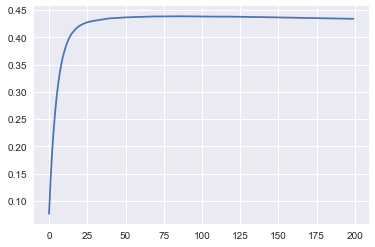

In [150]:
plt.plot(gbr.oob_improvement_.cumsum())

In [151]:
feats_imp = pd.DataFrame({'cols': X_train.columns, 'imp': gbr.feature_importances_})
feats_imp.sort_values(by='imp', ascending=False, inplace=True)
feats_imp.head(20)

,cols,imp
154,visitors_mv,0.039150
68,ratio_s_w,0.035499
6,date_int,0.029885
70,mean_s_d,0.024049
75,ratio_s_d,0.023212
5,doy,0.022252
71,median_s_d,0.021991
67,max_s_w,0.021541
17,median_visitors,0.020692
66,median_s_w,0.018728


## Model and Predict #1

In [83]:
# 辅助计时函数
def time_cnt(delta):
    total_secs = int(delta.total_seconds())
    format = '{h}H: {m}M: {s}S'
    h, m = total_secs // 3600, total_secs % 3600
    m, s = m // 60, m % 60
    return format.format(h=h, m=m, s=s)

In [84]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors', 'air_genre_name', 'air_area_name']]

time0 = datetime.now()
print("Modeling...")
model1 = GradientBoostingRegressor(learning_rate=0.2, random_state=3)
model2 = KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

print("Training...")
# model1
model1.fit(train[col], np.log1p(train['visitors'].values))
visitors_pred1 = model1.predict(train[col])
print("Time consume: ", time_cnt(datetime.now()-time0))

# model2
time0 = datetime.now()
model2.fit(train[col], np.log1p(train['visitors'].values))
visitors_pred2 = model2.predict(train[col])

print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), visitors_pred1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), visitors_pred2))
print("Time consume: ", time_cnt(datetime.now()-time0))

Modeling...
Training...
Time consume:  0H: 4M: 48S
RMSE GradientBoostingRegressor:  0.456443449301
RMSE KNeighborsRegressor:  0.489168172841
Time consume:  0H: 4M: 43S


## Model and Predict #2 Moving Average

In [152]:
visitors_mv.head()

,air_store_id,dow,holiday_flg,visitors_mv
0,air_00a91d42b08b08d9,0,0.0,3.203625
1,air_00a91d42b08b08d9,0,1.0,3.091042
2,air_00a91d42b08b08d9,1,0.0,3.325868
3,air_00a91d42b08b08d9,2,0.0,3.353439
4,air_00a91d42b08b08d9,3,0.0,3.475056


In [73]:
def mean_avg(tra, hol):
    air_visit_data = tra.copy()
    date_info = hol.copy()
    # 把周末的holiday_flag置为0
    date_info.loc[(date_info['visit_date'].dt.dayofweek>4) & date_info['holiday_flg']==1, :] = 0

    # 根据hol.index计算日期对应的权重weight
    date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

    # 在visit_data中匹配日期weight
    visit_data = air_visit_data.merge(date_info, on='visit_date', how='left')

    # 将访问量转化为对数访问量log1p
    visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

    # 按照 air_store_id, dow, holiday_flg 的分组计算加权平均
    visitors = visit_data.groupby(['air_store_id', 'dow', 'holiday_flg']).apply(
        lambda x:( (x['weight'] * x['visitors']).sum() / x['weight'].sum() )).reset_index()
    visitors.rename(columns={0:'visitors'}, inplace=True) 
    return visitors

In [176]:
visitors_mv.head(2)

,air_store_id,dow,holiday_flg,visitors_mv
0,air_00a91d42b08b08d9,0,0.0,3.203625
1,air_00a91d42b08b08d9,0,1.0,3.091042


In [178]:
test.head()

,id,visitors,visit_date,air_store_id,dow,month,season,week,rs1_x,rv1_x,...,air_area_name5,air_area_name6,var_max_lat,var_max_long,lon_plus_lat,holiday_flg,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,visitors_mv
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,4,2,16,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,1.098612
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.203625
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.325868
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.353439
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.475056


## 生成提交文件

In [74]:
sub1 = test[['id','visitors']].copy()
sub1['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
sub1['visitors'] = np.expm1(sub1['visitors']).clip(lower=0.)

In [75]:
sub2 = test[['id', 'visitors_mv']].copy()
sub2['visitors'] = sub2['visitors_mv'].map(pd.np.expm1)

In [197]:
sub2.head()

,id,visitors_mv,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.098612,2.000000
1,air_00a91d42b08b08d9_2017-04-24,3.203625,23.621632
2,air_00a91d42b08b08d9_2017-04-25,3.325868,26.823130
3,air_00a91d42b08b08d9_2017-04-26,3.353439,27.600920
4,air_00a91d42b08b08d9_2017-04-27,3.475056,31.299646


In [76]:
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')
sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2
sub_merge[['id', 'visitors']].to_csv('submission%s.csv' % datetime.now().strftime('%M%S'), index=False)